In [413]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-insurance-claim-pediction-dataverse-2022/sample_submission.csv
/kaggle/input/av-insurance-claim-pediction-dataverse-2022/train.csv
/kaggle/input/av-insurance-claim-pediction-dataverse-2022/test.csv


In [414]:
import pandas as pd
import numpy as np
import seaborn as sns  
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split
import time

from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance

import lightgbm as lgb
from sklearn.metrics import f1_score
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn import model_selection, metrics, decomposition, preprocessing
import matplotlib.pyplot as plt

%matplotlib inline

SEED = 1

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [415]:
filepath = "/kaggle/input/av-insurance-claim-pediction-dataverse-2022"

In [416]:
train_df = pd.read_csv(filepath+'/train.csv')
test_df = pd.read_csv(filepath+'/test.csv')
sub_df = pd.read_csv(filepath+'/sample_submission.csv')
train_df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [417]:
sub_df['is_claim'].value_counts()

1    39063
Name: is_claim, dtype: int64

In [418]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())

Number of samples in train: 58592
Number of columns in train: 44


In [419]:
print(f'Number of samples in test: {test_df.shape[0]}')
print(f'Number of columns in test: {test_df.shape[1]}')
for col in test_df.columns:
    if test_df[col].isnull().any():
        print(col, test_df[col].isnull().sum())

Number of samples in test: 39063
Number of columns in test: 43


In [420]:
train_df['is_claim'].value_counts(normalize=True)

0    0.936032
1    0.063968
Name: is_claim, dtype: float64

In [421]:
test_df.columns

Index(['policy_id', 'policy_tenure', 'age_of_car', 'age_of_policyholder',
       'area_cluster', 'population_density', 'make', 'segment', 'model',
       'fuel_type', 'max_torque', 'max_power', 'engine_type', 'airbags',
       'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder',
       'transmission_type', 'gear_box', 'steering_type', 'turning_radius',
       'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating'],
      dtype='object')

In [422]:
#filter only object columns
chk = train_df.select_dtypes(include=[object])

In [423]:
chk.columns

Index(['policy_id', 'area_cluster', 'segment', 'model', 'fuel_type',
       'max_torque', 'max_power', 'engine_type', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'transmission_type',
       'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert'],
      dtype='object')

In [424]:
#find levels in categorical data
for col in chk.columns:
  print('The unique values of '+col+' column {} in test dataset are'.format(chk[col].nunique()))

The unique values of policy_id column 58592 in test dataset are
The unique values of area_cluster column 22 in test dataset are
The unique values of segment column 6 in test dataset are
The unique values of model column 11 in test dataset are
The unique values of fuel_type column 3 in test dataset are
The unique values of max_torque column 9 in test dataset are
The unique values of max_power column 9 in test dataset are
The unique values of engine_type column 11 in test dataset are
The unique values of is_esc column 2 in test dataset are
The unique values of is_adjustable_steering column 2 in test dataset are
The unique values of is_tpms column 2 in test dataset are
The unique values of is_parking_sensors column 2 in test dataset are
The unique values of is_parking_camera column 2 in test dataset are
The unique values of rear_brakes_type column 2 in test dataset are
The unique values of transmission_type column 2 in test dataset are
The unique values of steering_type column 3 in test d

In [425]:
#find levels in categorical data
for col in chk.columns:
  print('The unique values of '+col+' column {} in test dataset are'.format(test_df[col].nunique()))

The unique values of policy_id column 39063 in test dataset are
The unique values of area_cluster column 22 in test dataset are
The unique values of segment column 6 in test dataset are
The unique values of model column 11 in test dataset are
The unique values of fuel_type column 3 in test dataset are
The unique values of max_torque column 9 in test dataset are
The unique values of max_power column 9 in test dataset are
The unique values of engine_type column 11 in test dataset are
The unique values of is_esc column 2 in test dataset are
The unique values of is_adjustable_steering column 2 in test dataset are
The unique values of is_tpms column 2 in test dataset are
The unique values of is_parking_sensors column 2 in test dataset are
The unique values of is_parking_camera column 2 in test dataset are
The unique values of rear_brakes_type column 2 in test dataset are
The unique values of transmission_type column 2 in test dataset are
The unique values of steering_type column 3 in test d

In [426]:
# Importing LabelEncoder and initializing it
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Iterating over all the common columns in train and test
for col in train_df.columns.values:
    # Encoding only categorical variables
    if train_df[col].dtypes=='object':
        print(col)
        # Using whole data to form an exhaustive list of levels
        data=train_df[col].append(test_df[col])
        le.fit(data.values)        
        train_df[col]=le.transform(train_df[col])
        test_df[col]=le.transform(test_df[col])

policy_id
area_cluster
segment
model
fuel_type
max_torque
max_power
engine_type
is_esc
is_adjustable_steering
is_tpms
is_parking_sensors
is_parking_camera
rear_brakes_type
transmission_type
steering_type
is_front_fog_lights
is_rear_window_wiper
is_rear_window_washer
is_rear_window_defogger
is_brake_assist
is_power_door_locks
is_central_locking
is_power_steering
is_driver_seat_height_adjustable
is_day_night_rear_view_mirror
is_ecw
is_speed_alert


In [427]:
train_df.head(3)

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0,0.515874,0.05,0.644231,0,4990,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,1,0.672619,0.02,0.375000,11,27003,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,2,0.841110,0.02,0.384615,15,4076,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [428]:
train_df.shape

(58592, 44)

In [429]:
# * join the datasets
train_df['is_train']  = 1
test_df['is_claim'] = 0
test_df['is_train'] = 0
full_df = train_df.append(test_df)

In [430]:
full_df.shape

(97655, 45)

In [431]:

area_cluster_grpd = full_df.groupby(['model']).agg({
                                                    'policy_tenure': ['mean', 'max', 'min', 'std'],
                                                     'age_of_car': ['mean', 'max', 'min', 'std'], 
                                                     'age_of_policyholder': ['mean', 'max', 'min', 'std'],
                                                     'population_density': ['mean', 'max', 'min', 'std'],
                                                     })
area_cluster_grpd.columns = ['grpd_by_model_' + '_'.join(c).strip('_') for c in area_cluster_grpd.columns]
full_df = pd.merge(full_df, area_cluster_grpd, on = ['model'], how='left')


area_cluster_grpd = full_df.groupby(['max_torque']).agg({
                                                    'policy_tenure': ['mean', 'max', 'min', 'std'],
                                                     'age_of_car': ['mean', 'max', 'min', 'std'], 
                                                     'age_of_policyholder': ['mean', 'max', 'min', 'std'],
                                                     'population_density': ['mean', 'max', 'min', 'std'],
                                                     })
area_cluster_grpd.columns = ['grpd_by_max_torque_' + '_'.join(c).strip('_') for c in area_cluster_grpd.columns]
full_df = pd.merge(full_df, area_cluster_grpd, on = ['max_torque'], how='left')

    

In [432]:
full_df.shape

(97655, 77)

In [433]:
full_df['unique_area_cluster_in_segment_model']=full_df.groupby(['area_cluster','segment'])['model'].transform('nunique')
full_df['unique_area_cluster_in_segment_max_torque']=full_df.groupby(['area_cluster','segment'])['max_torque'].transform('nunique')

full_df['unique_model_max_torque_area_cluster']=full_df.groupby(['model','max_torque'])['area_cluster'].transform('count')
full_df['count_model_max_torque_segment']=full_df.groupby(['model','max_torque'])['segment'].transform('count')



full_df['std_area_cluster_segment_policy_tenure']=full_df.groupby(['area_cluster','segment'])['policy_tenure'].transform('std')
full_df['std_area_cluster_segment_age_of_car']=full_df.groupby(['area_cluster','segment'])['age_of_car'].transform('std')

full_df['std_model_max_torque_policy_tenure']=full_df.groupby(['model','max_torque'])['policy_tenure'].transform('std')
full_df['std_model_max_torque_age_of_car']=full_df.groupby(['model','max_torque'])['age_of_car'].transform('std')

In [434]:
full_df.shape

(97655, 85)

In [435]:
## pivot on ID and apache_3j_diagnosis
gdf = pd.pivot_table(full_df, columns="area_cluster", index="model", values = "policy_id",
                     aggfunc="count", fill_value=0).reset_index().add_prefix('area_cluster_')

full_df = pd.merge(full_df, gdf, left_on="area_cluster", right_on = 'area_cluster_model', how="left")
del gdf
full_df.head()

### pivot on ID and apache_3j_diagnosis
gdf = pd.pivot_table(full_df, columns="max_torque", index="model", values = "policy_id",
                     aggfunc="count", fill_value=0).reset_index().add_prefix('max_torque_')

full_df = pd.merge(full_df, gdf, left_on="max_torque", right_on = 'max_torque_model', how="left")
del gdf
full_df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,is_train,grpd_by_model_policy_tenure_mean,grpd_by_model_policy_tenure_max,grpd_by_model_policy_tenure_min,grpd_by_model_policy_tenure_std,grpd_by_model_age_of_car_mean,...,grpd_by_max_torque_age_of_car_std,grpd_by_max_torque_age_of_policyholder_mean,grpd_by_max_torque_age_of_policyholder_max,grpd_by_max_torque_age_of_policyholder_min,grpd_by_max_torque_age_of_policyholder_std,grpd_by_max_torque_population_density_mean,grpd_by_max_torque_population_density_max,grpd_by_max_torque_population_density_min,grpd_by_max_torque_population_density_std,unique_area_cluster_in_segment_model,unique_area_cluster_in_segment_max_torque,unique_model_max_torque_area_cluster,count_model_max_torque_segment,std_area_cluster_segment_policy_tenure,std_area_cluster_segment_age_of_car,std_model_max_torque_policy_tenure,std_model_max_torque_age_of_car,area_cluster_model,area_cluster_0,area_cluster_1,area_cluster_2,area_cluster_3,area_cluster_4,area_cluster_5,area_cluster_6,area_cluster_7,area_cluster_8,area_cluster_9,area_cluster_10,area_cluster_11,area_cluster_12,area_cluster_13,area_cluster_14,area_cluster_15,area_cluster_16,area_cluster_17,area_cluster_18,area_cluster_19,area_cluster_20,area_cluster_21,max_torque_model,max_torque_0,max_torque_1,max_torque_2,max_torque_3,max_torque_4,max_torque_5,max_torque_6,max_torque_7,max_torque_8
0,0,0.515874,0.05,0.644231,0,4990,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0.445632,1.312976,0.002745,0.335940,0.025670,...,0.030659,0.479243,0.990385,0.288462,0.119543,21773.909477,73430,290,20481.571393,2,2,24988,24988,0.325393,0.027408,0.335940,0.030659,0.0,1232.0,2029.0,499.0,414.0,920.0,537.0,339.0,486.0,434.0,302.0,277.0,2677.0,93.0,225.0,114.0,5540.0,484.0,4289.0,504.0,1143.0,938.0,1512.0,5,0,0,0,0,23383,0,0,0,0
1,1,0.672619,0.02,0.375000,11,27003,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0.445632,1.312976,0.002745,0.335940,0.025670,...,0.030659,0.479243,0.990385,0.288462,0.119543,21773.909477,73430,290,20481.571393,2,2,24988,24988,0.370886,0.044175,0.335940,0.030659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,0,23383,0,0,0,0
2,2,0.841110,0.02,0.384615,15,4076,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0.445632,1.312976,0.002745,0.335940,0.025670,...,0.030659,0.479243,0.990385,0.288462,0.119543,21773.909477,73430,290,20481.571393,2,2,24988,24988,0.322167,0.028849,0.335940,0.030659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,0,23383,0,0,0,0
3,3,0.900277,0.11,0.432692,16,21622,1,3,3,2,0,6,2,2,1,1,0,1,1,1,1197,4,0,5,0,4.8,3995,1735,1515,1335,1,0,0,1,1,1,1,1,1,1,1,1,2,0,1,0.642063,1.248713,0.002783,0.418508,0.084162,...,0.054489,0.475098,1.000000,0.288462,0.128054,17540.757889,73430,290,16394.168493,3,3,1790,1790,0.389895,0.058461,0.418508,0.052956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,24988,0,0,0
4,4,0.596403,0.11,0.634615,17,34738,2,0,4,2,8,5,0,2,0,0,0,0,1,1,999,3,0,5,0,5.0,3731,1579,1490,1155,0,0,0,0,0,1,1,1,0,1,1,1,2,0,1,0.642392,1.396641,0.002773,0.425042,0.076796,...,0.051017,0.454990,0.951923,0.288462,0.114360,19729.499627,73430,290,17003.801752,2,2,4023,4023,0.345352,

In [436]:
full_df.tail()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,is_train,grpd_by_model_policy_tenure_mean,grpd_by_model_policy_tenure_max,grpd_by_model_policy_tenure_min,grpd_by_model_policy_tenure_std,grpd_by_model_age_of_car_mean,...,grpd_by_max_torque_age_of_car_std,grpd_by_max_torque_age_of_policyholder_mean,grpd_by_max_torque_age_of_policyholder_max,grpd_by_max_torque_age_of_policyholder_min,grpd_by_max_torque_age_of_policyholder_std,grpd_by_max_torque_population_density_mean,grpd_by_max_torque_population_density_max,grpd_by_max_torque_population_density_min,grpd_by_max_torque_population_density_std,unique_area_cluster_in_segment_model,unique_area_cluster_in_segment_max_torque,unique_model_max_torque_area_cluster,count_model_max_torque_segment,std_area_cluster_segment_policy_tenure,std_area_cluster_segment_age_of_car,std_model_max_torque_policy_tenure,std_model_max_torque_age_of_car,area_cluster_model,area_cluster_0,area_cluster_1,area_cluster_2,area_cluster_3,area_cluster_4,area_cluster_5,area_cluster_6,area_cluster_7,area_cluster_8,area_cluster_9,area_cluster_10,area_cluster_11,area_cluster_12,area_cluster_13,area_cluster_14,area_cluster_15,area_cluster_16,area_cluster_17,area_cluster_18,area_cluster_19,area_cluster_20,area_cluster_21,max_torque_model,max_torque_0,max_torque_1,max_torque_2,max_torque_3,max_torque_4,max_torque_5,max_torque_6,max_torque_7,max_torque_8
97650,97650,0.047982,0.15,0.740385,11,27003,1,2,7,2,0,6,8,2,0,1,0,1,0,1,1197,4,1,5,0,4.80,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0,0,0.691480,1.391398,0.002739,0.423393,0.086402,...,0.054489,0.475098,1.000000,0.288462,0.128054,17540.757889,73430,290,16394.168493,3,2,22827,22827,0.418987,0.052179,0.423393,0.054815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,24988,0,0,0
97651,97651,1.224838,0.05,0.509615,20,8794,3,4,5,1,4,0,3,6,1,1,1,1,1,0,1493,4,0,6,2,5.20,4300,1790,1635,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,0,0,0.678555,1.353960,0.002735,0.424661,0.089264,...,0.057348,0.468504,0.971154,0.288462,0.123702,17055.338964,73430,290,15926.160176,1,1,23383,23383,0.406406,0.058860,0.424661,0.057348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0,0,0,0,0,0,0,0,4023
97652,97652,0.520287,0.12,0.355769,18,13051,1,2,8,2,0,6,1,6,1,1,0,1,1,1,1197,4,0,5,0,4.85,3990,1745,1500,1410,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0.668452,1.382933,0.002759,0.423205,0.084681,...,0.054489,0.475098,1.000000,0.288462,0.128054,17540.757889,73430,290,16394.168493,3,2,4886,4886,0.426730,0.051821,0.423205,0.053482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,24988,0,0,0
97653,97653,1.172391,0.08,0.644231,17,34738,1,3,3,2,0,6,2,2,1,1,0,1,1,1,1197,4,0,5,0,4.80,3995,1735,1515,1335,1,0,0,1,1,1,1,1,1,1,1,1,2,0,0,0.642063,1.248713,0.002783,0.418508,0.084162,...,0.054489,0.475098,1.000000,0.288462,0.128054,17540.757889,73430,290,16394.168493,3,3,1790,1790,0.405576,0.053058,0.418508,0.052956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,24988,0,0,0
97654,97654,0.094030,0.12,0.307692,20,8794,3,4,5,1,4,0,3,6,1,1,1,1,1,0,1493,4,0,6,2,5.20,4300,1790,1635,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,0,0,0.678555,1.353960,0.002735,0.424661,0.089264,...,0.057348,0.468504,0.971154,0.288462,0.123702,17055.338964,73430,290,15926.160176,1,1,23383,23383,0.406406,0

In [437]:
# append train and test data
testcount = len(test_df)
count = len(full_df)-testcount
print(count)

train = full_df[:count]
test = full_df[count:]
train_df = train.copy()
test_df = test.copy()

58592


In [438]:
X=train_df.drop(columns={'policy_id', 'is_train','is_claim'},axis=1)
y=train_df.loc[:,['is_claim']]

test_X=test_df.drop(columns={'policy_id', 'is_train','is_claim'},axis=1)


print(X.shape, y.shape, test_X.shape)

(58592, 115) (58592, 1) (39063, 115)


In [439]:
X.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,grpd_by_model_policy_tenure_mean,grpd_by_model_policy_tenure_max,grpd_by_model_policy_tenure_min,grpd_by_model_policy_tenure_std,grpd_by_model_age_of_car_mean,grpd_by_model_age_of_car_max,grpd_by_model_age_of_car_min,grpd_by_model_age_of_car_std,...,grpd_by_max_torque_age_of_car_std,grpd_by_max_torque_age_of_policyholder_mean,grpd_by_max_torque_age_of_policyholder_max,grpd_by_max_torque_age_of_policyholder_min,grpd_by_max_torque_age_of_policyholder_std,grpd_by_max_torque_population_density_mean,grpd_by_max_torque_population_density_max,grpd_by_max_torque_population_density_min,grpd_by_max_torque_population_density_std,unique_area_cluster_in_segment_model,unique_area_cluster_in_segment_max_torque,unique_model_max_torque_area_cluster,count_model_max_torque_segment,std_area_cluster_segment_policy_tenure,std_area_cluster_segment_age_of_car,std_model_max_torque_policy_tenure,std_model_max_torque_age_of_car,area_cluster_model,area_cluster_0,area_cluster_1,area_cluster_2,area_cluster_3,area_cluster_4,area_cluster_5,area_cluster_6,area_cluster_7,area_cluster_8,area_cluster_9,area_cluster_10,area_cluster_11,area_cluster_12,area_cluster_13,area_cluster_14,area_cluster_15,area_cluster_16,area_cluster_17,area_cluster_18,area_cluster_19,area_cluster_20,area_cluster_21,max_torque_model,max_torque_0,max_torque_1,max_torque_2,max_torque_3,max_torque_4,max_torque_5,max_torque_6,max_torque_7,max_torque_8
0,0.515874,0.05,0.644231,0,4990,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.445632,1.312976,0.002745,0.335940,0.025670,0.50,0.0,0.030659,...,0.030659,0.479243,0.990385,0.288462,0.119543,21773.909477,73430,290,20481.571393,2,2,24988,24988,0.325393,0.027408,0.335940,0.030659,0.0,1232.0,2029.0,499.0,414.0,920.0,537.0,339.0,486.0,434.0,302.0,277.0,2677.0,93.0,225.0,114.0,5540.0,484.0,4289.0,504.0,1143.0,938.0,1512.0,5,0,0,0,0,23383,0,0,0,0
1,0.672619,0.02,0.375000,11,27003,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.445632,1.312976,0.002745,0.335940,0.025670,0.50,0.0,0.030659,...,0.030659,0.479243,0.990385,0.288462,0.119543,21773.909477,73430,290,20481.571393,2,2,24988,24988,0.370886,0.044175,0.335940,0.030659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,0,23383,0,0,0,0
2,0.841110,0.02,0.384615,15,4076,1,0,0,0,5,2,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.445632,1.312976,0.002745,0.335940,0.025670,0.50,0.0,0.030659,...,0.030659,0.479243,0.990385,0.288462,0.119543,21773.909477,73430,290,20481.571393,2,2,24988,24988,0.322167,0.028849,0.335940,0.030659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,0,23383,0,0,0,0
3,0.900277,0.11,0.432692,16,21622,1,3,3,2,0,6,2,2,1,1,0,1,1,1,1197,4,0,5,0,4.8,3995,1735,1515,1335,1,0,0,1,1,1,1,1,1,1,1,1,2,0.642063,1.248713,0.002783,0.418508,0.084162,0.39,0.0,0.052956,...,0.054489,0.475098,1.000000,0.288462,0.128054,17540.757889,73430,290,16394.168493,3,3,1790,1790,0.389895,0.058461,0.418508,0.052956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,24988,0,0,0
4,0.596403,0.11,0.634615,17,34738,2,0,4,2,8,5,0,2,0,0,0,0,1,1,999,3,0,5,0,5.0,3731,1579,1490,1155,0,0,0,0,0,1,1,1,0,1,1,1,2,0.642392,1.396641,0.002773,0.425042,0.076796,0.76,0.

In [440]:
X.shape, test_X.shape

((58592, 115), (39063, 115))

In [441]:
features = X.columns

In [442]:
X.shape, test_X.shape

((58592, 115), (39063, 115))

## LightGBM

In [467]:
ts = time.time()


params={
    'random_state': 42,
#     'reg_alpha': 0.015560063186597707, 'reg_lambda': 8.938427291425283, 
#     'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.03,
#     'max_depth': 5, 'num_leaves': 519, 'min_child_samples': 198, 'cat_smooth': 6
    
    'reg_alpha': 0.001217255397536408,
     'reg_lambda': 2.0031859335159994,
     'colsample_bytree': 0.5,
     'subsample': 0.7,
     'learning_rate': 0.008,
     'max_depth': 5,
     'num_leaves': 863,
     'min_child_samples': 208,
     'cat_smooth': 89
}


err = [] 

oofs = np.zeros(shape=(len(X)))
preds = np.zeros(shape=(len(test_X)))

Folds=10

fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=42)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    m = LGBMClassifier(n_estimators=10000,**params)

    m.fit(x_train, y_train,eval_set=[(x_val, y_val)],
          early_stopping_rounds =30,verbose=False)

    pred_y = m.predict_proba(x_val)[:,1]
    threshlimit = 0.085
    pred_y = np.where(pred_y > threshlimit, 1, 0).tolist()

    oofs[test_index] = pred_y
    print(i, " err_lgbm: ", f1_score(y_val,pred_y))
    err.append(f1_score(y_val,pred_y))
    preds+= m.predict_proba(test_X)[:,1]
    i = i + 1
preds=preds/Folds

print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
oof_score = f1_score(y, oofs)
print(f'\nOOF Auc is : {oof_score}')

oofs=pd.DataFrame(oofs,columns=['lgboof'])
preds=pd.DataFrame(preds,columns=['lgbpred'])

oofs.to_csv('lgbmoof.csv',index=False)
preds.to_csv('lgbmpred.csv',index=False)

print("Time to execute is : ",time.time() - ts)


1  err_lgbm:  0.17835051546391753
2  err_lgbm:  0.15843621399176958
3  err_lgbm:  0.15991692627206644
4  err_lgbm:  0.17667844522968199
5  err_lgbm:  0.1785525620707871
6  err_lgbm:  0.18825910931174086
7  err_lgbm:  0.18323789692868298
8  err_lgbm:  0.18474312402698492
9  err_lgbm:  0.16564758198999444
10  err_lgbm:  0.17051874678993323
Average StratifiedKFold Score : 0.17443411220755592 

OOF Auc is : 0.17450919289498287
Time to execute is :  92.6917839050293


In [468]:
# Average StratifiedKFold Score : 0.1709430998628366 
# OOF Auc is : 0.17100450569838327
# Average StratifiedKFold Score : 0.17423492430123205
# OOF Auc is : 0.17428586187303066

# Average StratifiedKFold Score : 0.17443411220755592 
# OOF Auc is : 0.17450919289498287

<AxesSubplot:>

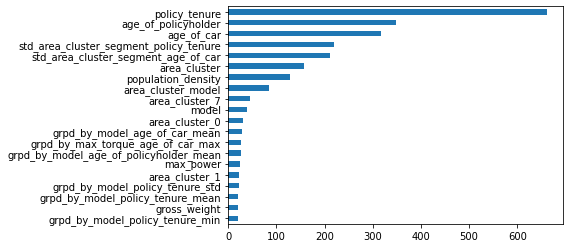

In [445]:
fi = pd.Series(index = X.columns, data = m.feature_importances_)
fi.sort_values(ascending=False)[0:20][::-1].plot(kind = 'barh')

In [446]:
sub_df.head()

,policy_id,is_claim
0,ID58593,1
1,ID58594,1
2,ID58595,1
3,ID58596,1
4,ID58597,1


In [447]:
sub_df.shape

(39063, 2)

In [448]:
def custom_clip(x):
    if x > threshlimit:
        return 1
    else:
        return 0

In [449]:
sub_df['is_claim'] = preds['lgbpred'].apply(custom_clip)

In [450]:
sub_df['is_claim'].value_counts(normalize=True)

0    0.72977
1    0.27023
Name: is_claim, dtype: float64

In [451]:
sub_df['is_claim'].value_counts()

0    28507
1    10556
Name: is_claim, dtype: int64

In [452]:
sub_df.to_csv("lgb_submission.csv",index=False)

## CatBoost

In [453]:
X.dtypes

policy_tenure                                  float64
age_of_car                                     float64
age_of_policyholder                            float64
area_cluster                                     int64
population_density                               int64
make                                             int64
segment                                          int64
model                                            int64
fuel_type                                        int64
max_torque                                       int64
max_power                                        int64
engine_type                                      int64
airbags                                          int64
is_esc                                           int64
is_adjustable_steering                           int64
is_tpms                                          int64
is_parking_sensors                               int64
is_parking_camera                                int64
rear_brake

In [454]:
ts = time.time()

# params={
#     'random_state': 42
# }

params={
    'random_state': 42,

    }


err = [] 

oofs = np.zeros(shape=(len(X)))
preds = np.zeros(shape=(len(test_X)))

Folds=10

fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=42)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    m = CatBoostClassifier(n_estimators=10000,**params)

    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds =30,
#           cat_features=categorical_features_indices,
          verbose=False)

    pred_y = m.predict_proba(x_val)[:,1]
    threshlimit = 0.085
    pred_y = np.where(pred_y > threshlimit, 1, 0).tolist()
    oofs[test_index] = pred_y
    print(i, " err_cb: ", f1_score(y_val,pred_y))
    err.append(f1_score(y_val,pred_y))
    preds+= m.predict_proba(test_X)[:,1]
    i = i + 1
preds=preds/Folds

print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
oof_score = f1_score(y, oofs)
print(f'\nOOF Auc is : {oof_score}')

oofs=pd.DataFrame(oofs,columns=['cboof'])
preds=pd.DataFrame(preds,columns=['cbpred'])

oofs.to_csv('cbmoof.csv',index=False)
preds.to_csv('cbmpred.csv',index=False)

print("Time to execute is : ",time.time() - ts)


1  err_cb:  0.18028465998945703
2  err_cb:  0.15477386934673368
3  err_cb:  0.16362688900468994
4  err_cb:  0.17115689381933435
5  err_cb:  0.18327117741076182
6  err_cb:  0.19062664560294892
7  err_cb:  0.18251366120218576
8  err_cb:  0.19324675324675325
9  err_cb:  0.1712104689203926
10  err_cb:  0.16565040650406507
Average StratifiedKFold Score : 0.17563614250473225 

OOF Auc is : 0.17549390500210174
Time to execute is :  69.16478204727173


<AxesSubplot:>

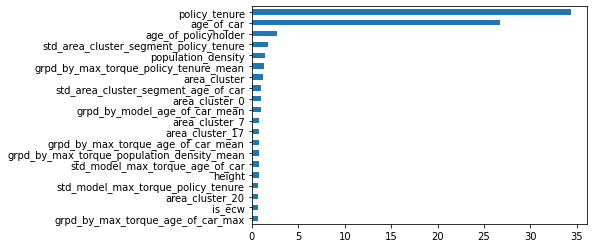

In [455]:
fi = pd.Series(index = X.columns, data = m.feature_importances_)
fi.sort_values(ascending=False)[0:20][::-1].plot(kind = 'barh')

In [456]:
fi.sort_values(ascending=False)[0:20][::-1]

grpd_by_max_torque_age_of_car_max              0.623250
is_ecw                                         0.650787
area_cluster_20                                0.670027
std_model_max_torque_policy_tenure             0.693060
height                                         0.722899
std_model_max_torque_age_of_car                0.750072
grpd_by_max_torque_population_density_mean     0.753432
grpd_by_max_torque_age_of_car_mean             0.775785
area_cluster_17                                0.790527
area_cluster_7                                 0.799259
grpd_by_model_age_of_car_mean                  0.934168
area_cluster_0                                 0.952250
std_area_cluster_segment_age_of_car            0.978936
area_cluster                                   1.194585
grpd_by_max_torque_policy_tenure_mean          1.333447
population_density                             1.421214
std_area_cluster_segment_policy_tenure         1.688668
age_of_policyholder                            2

In [457]:
sub_df['is_claim'] = preds['cbpred'].apply(custom_clip)
sub_df['is_claim'].value_counts()

0    28730
1    10333
Name: is_claim, dtype: int64

In [458]:
sub_df.to_csv("cb_submission.csv",index=False)

## Ensemble solution

In [469]:
threshlimit = 0.085

In [470]:
lgbm = pd.read_csv("lgbmpred.csv")
cbm = pd.read_csv("cbmpred.csv")


final = (lgbm['lgbpred'] + cbm['cbpred'] )/2
final.head()

0    0.140496
1    0.059699
2    0.042786
3    0.044749
4    0.067186
dtype: float64

In [471]:
sub_df.head()

,policy_id,is_claim
0,ID58593,1
1,ID58594,0
2,ID58595,0
3,ID58596,0
4,ID58597,0


In [472]:
sub_df['is_claim'] = final.apply(custom_clip)
sub_df['is_claim'].value_counts()

0    28690
1    10373
Name: is_claim, dtype: int64

In [473]:
sub_df.to_csv("lgbm_cb_submission.csv",index=False)  #final submission

In [474]:
lgbm = pd.read_csv("lgbmpred.csv")
cbm = pd.read_csv("cbmpred.csv")

final = (lgbm['lgbpred']*0.6 + cbm['cbpred']*0.4)
final.head()

0    0.142147
1    0.060767
2    0.043366
3    0.043439
4    0.067038
dtype: float64

In [475]:
sub_df['is_claim'] = final.apply(custom_clip)
sub_df['is_claim'].value_counts()

0    28688
1    10375
Name: is_claim, dtype: int64

In [476]:
sub_df.to_csv("lgbm_cb_submission_6040.csv",index=False)